# Imports

In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

import pandas as pd
import util.common as util
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import pathlib
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from util.AUROCEarlyStoppingPruneCallback import AUROCEarlyStoppingPruneCallback

2022-07-15 04:21:19.948946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 04:21:19.948965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/users/mverkerk/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data 
Download data into local folder https://gitlab.ilabt.imec.be/mverkerk/ids-dataset-cleaning

In [2]:
train = {
    "ocsvm": {}, # 10k samples
    "ae": {}, # 100k samples
    "stage2": {}
}
val = {
    "ocsvm": {},
    "ae": {},
    "stage2": {}
}
test = {
    # "y"
    # "y_binary"
    # "y_unknown"
    # "x"
}

## Load Data Stage 1

In [3]:
clean_dir = "/groups/ilabt-imec-be/phdmiel/data/cicids2017/clean/"


train["ocsvm"]["x"], train["ocsvm"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = util.load_data(clean_dir, sample_size=1948, train_size=10000, val_size=129485, test_size=56468)

val["ocsvm"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ocsvm"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))


train["ae"]["x"], train["ae"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = util.load_data(clean_dir, sample_size=1948, val_size=129485, test_size=56468)

val["ae"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ae"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2071822    195953   10000   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        63       0   
             DoS Hulk                       172726      1046       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5383        33       0   
             ALL                            321637      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

## Load Data Stage 2

In [4]:
n_benign_val = 1500

x_benign_train, _, _, _, x_benign_test, y_benign_test, x_malicious_train, y_malicious_train, x_malicious_test, y_malicious_test, attack_type_train, _, _ = util.load_data(clean_dir, sample_size=1948, train_size=n_benign_val, val_size=6815, test_size=56468)
train["stage2"]["x"], x_val, train["stage2"]["y"], y_val = train_test_split(x_malicious_train, y_malicious_train, stratify=attack_type_train, test_size=1500, random_state=42, shuffle=True)

test['x'] = np.concatenate((x_benign_test, x_malicious_test))
test["y_n"] = np.concatenate((y_benign_test, np.full(y_malicious_test.shape[0], -1)))

val["stage2"]["x"] = np.concatenate((x_val, x_benign_train))
val["stage2"]["y"] = np.concatenate((y_val, np.full(n_benign_val, "Unknown")))

train["stage2"]["y_n"] = pd.get_dummies(train["stage2"]["y"])
val["stage2"]["y_n"] = pd.get_dummies(val["stage2"]["y"])

test["y"] = np.concatenate((np.full(56468, "Benign"), y_malicious_test))
test["y_unknown"] = np.where((test["y"] == "Heartbleed") | (test["y"] == "Infiltration"), "Unknown", test["y"])
test["y_unknown_all"] = np.where(test['y_unknown'] == 'Benign', "Unknown", test['y_unknown'])

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2071822     64783    1500   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        63       0   
             DoS Hulk                       172726      1046       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5383        33       0   
             ALL                            321637      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

## Scale the data

In [5]:
scaler = QuantileTransformer(output_distribution='normal')
train['ocsvm']['x_s'] = scaler.fit_transform(train['ocsvm']['x'])
val['ocsvm']['x_s'] = scaler.transform(val['ocsvm']['x'])
test['ocsvm_s'] = scaler.transform(test['x'])

scaler = QuantileTransformer(output_distribution='normal')
train['ae']['x_s'] = scaler.fit_transform(train['ae']['x'])
val['ae']['x_s'] = scaler.transform(val['ae']['x'])
test['ae_s'] = scaler.transform(test['x'])

scaler = QuantileTransformer(output_distribution='normal')
train['stage2']['x_s'] = scaler.fit_transform(train['stage2']['x'])
val['stage2']['x_s'] = scaler.transform(val['stage2']['x'])
test['stage2_s'] = scaler.transform(test['x'])

scaler = QuantileTransformer(output_distribution='uniform')
train['stage2']['x_q'] = scaler.fit_transform(train['stage2']['x'])
val['stage2']['x_q'] = scaler.transform(val['stage2']['x'])
test['stage2_q'] = scaler.transform(test['x'])

/users/mverkerk/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/users/mverkerk/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/users/mverkerk/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/users/mverkerk/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/users/mverkerk/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/users/mverkerk/.local/lib/python3.

# Fetch Best Hyperparameters 
see paper for experiment

In [6]:
f = open("results/predictions.pkl","rb")
predictions = pickle.load(f)
f.close()
f = open("results/thresholds.pkl","rb")
thresholds = pickle.load(f)
f.close()

## Best F1 score (macro & micro) and Accuracy

In [8]:
results_df = pd.read_csv("results/results_123.csv")
results_df.sort_values(by="ACC", ascending=False).head(1)

,index_1,threshold_b_fpr,threshold_b_metric,index_2,quantile,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
3876,3,0.312492,F6,9,0.995,0.895412,0.98765,0.98765,0.827638,0.989726,0.595745,6.234043


## Best Balanced Accuracy

In [10]:
results_df[(results_df.index_1 == 3)].sort_values(by="bACC", ascending=False).head(1)

,index_1,threshold_b_fpr,threshold_b_metric,index_2,quantile,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
4219,3,0.420867,F9,4,0.95,0.960784,0.934147,0.934147,0.749611,0.958032,0.957447,59.319149


## Best overall

In [9]:
results_df[results_df.zero_day_recall_extension > 0.7].sort_values(by="f1_weighted", ascending=False).head(1)

,index_1,threshold_b_fpr,threshold_b_metric,index_2,quantile,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
3757,3,0.312492,F5,9,0.99,0.934248,0.98336,0.98336,0.823098,0.987539,0.87234,12.212766


Look up corresponding thresholds from best models in tables below.\
**Example:** best overall model uses threshold_b corresponding with metric F5 and FPR of 0.312, this is equal to -0.0002196942507948895

In [10]:
thresholds["stage1"][3]

{('F1', 0.06332779858670888): 0.00045688301618681225,
 ('F2', 0.21074255705294048): -2.051400164242937e-05,
 ('F3', 0.21074255705294048): -2.051400164242937e-05,
 ('F4', 0.21074255705294048): -2.051400164242937e-05,
 ('F5', 0.3124917944163417): -0.0002196942507948895,
 ('F6', 0.3124917944163417): -0.0002196942507948895,
 ('F7', 0.3124917944163417): -0.0002196942507948895,
 ('F8', 0.3124917944163417): -0.0002196942507948895,
 ('F9', 0.42086728192454725): -0.0004064190600459828}

In [11]:
thresholds["stage2"][4]

0.9500000000000001

In [12]:
thresholds["stage2"][9]

0.98

In [13]:
thresholds["extension"][3]

{0.995: 0.004530129828299084,
 0.99: 0.0040588613744241275,
 0.975: 0.0021393036189165894,
 0.95: 0.0006590265510403005}

# Train Models
Code below shows training for best overall model

## STAGE 1: One-Class SVM

In [14]:
def create_ocsvm(params):
    return Pipeline(
        [
            ("pca", PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=42)), 
            ("ocsvm", OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=True, max_iter=-1))
        ]
    ).set_params(**params)

### Train

In [18]:
params_ocsvm = {
    "pca__n_components": 56,
    "ocsvm__kernel": "rbf",
    "ocsvm__gamma": 0.0632653906314333,
    "ocsvm__nu": 0.0002316646233151
}
ocsvm_model = create_ocsvm(params_ocsvm)
ocsvm_model.fit(train['ocsvm']['x_s'])

[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0


Pipeline(steps=[('pca', PCA(n_components=56, random_state=42)),
                ('ocsvm',
                 OneClassSVM(gamma=0.0632653906314333, nu=0.0002316646233151,
                             verbose=True))])

## Train with equal training size as AE (100k)

First is always original 10k trainingset, second is new 100k trainingset

In [15]:
params_ocsvm = {
    "pca__n_components": 56,
    "ocsvm__kernel": "rbf",
    "ocsvm__gamma": 0.0632653906314333,
    "ocsvm__nu": 0.0002316646233151
}
ocsvm_model = create_ocsvm(params_ocsvm)
ocsvm_model.fit(train['ae']['x_s'])

[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0


Pipeline(steps=[('pca', PCA(n_components=56, random_state=42)),
                ('ocsvm',
                 OneClassSVM(gamma=0.0632653906314333, nu=0.0002316646233151,
                             verbose=True))])

### Validation

In [16]:
score_val = -ocsvm_model.decision_function(val['ocsvm']['x_s'])
curves_metrics, summary_metrics = util.evaluate_proba(val['ocsvm']['y'], score_val)

In [17]:
score_val = -ocsvm_model.decision_function(val['ae']['x_s'])
curves_metrics, summary_metrics = util.evaluate_proba(val['ae']['y'], score_val)

In [46]:
summary_metrics

,metric,value,threshold,precision,recall,FPR
0,F1,0.4221,0.000415,0.4733,0.3809,0.022327
1,F2,0.4134,-0.000880,0.1817,0.6069,0.143955
2,F3,0.5175,-0.003107,0.1079,0.895,0.389682
3,F4,0.6358,-0.003829,0.0995,0.9585,0.456647
4,F5,0.7205,-0.004126,0.0958,0.9748,0.484628
5,F6,0.7814,-0.004200,0.0947,0.9784,0.492420
6,F7,0.8247,-0.004236,0.0942,0.9798,0.496374
7,F8,0.8563,-0.004363,0.0924,0.9833,0.508437
8,F9,0.8799,-0.004363,0.0924,0.9833,0.508437


#### Define Thresholds
Equal to 14 decimals after the comma as in original experiment

In [17]:
quantiles = [0.995, 0.99, 0.975, 0.95]
print({(metric, fpr): t for metric, fpr, t in zip(summary_metrics.metric, summary_metrics.FPR, summary_metrics.threshold)})
print({q: np.quantile(score_val[val["ocsvm"]["y"] == 1], q) for q in quantiles})

{('F1', 0.06332779858670888): 0.00045688301618776635, ('F2', 0.21074255705294048): -2.0514001641964465e-05, ('F3', 0.21074255705294048): -2.0514001641964465e-05, ('F4', 0.21074255705294048): -2.0514001641964465e-05, ('F5', 0.3124917944163417): -0.00021969425079637356, ('F6', 0.3124917944163417): -0.00021969425079637356, ('F7', 0.3124917944163417): -0.00021969425079637356, ('F8', 0.3124917944163417): -0.00021969425079637356, ('F9', 0.42086728192454725): -0.00040641906003620505}
{0.995: 0.004530129828297524, 0.99: 0.004058861374422596, 0.975: 0.002139303618915394, 0.95: 0.0006590265510394264}


In [18]:
quantiles = [0.995, 0.99, 0.975, 0.95]
print({(metric, fpr): t for metric, fpr, t in zip(summary_metrics.metric, summary_metrics.FPR, summary_metrics.threshold)})
print({q: np.quantile(score_val[val["ae"]["y"] == 1], q) for q in quantiles})

{('F1', 0.02232691045294822): 0.0004149375067814959, ('F2', 0.14395489825076263): -0.0008797428358914214, ('F3', 0.3896822025717265): -0.0031074653099050047, ('F4', 0.4566474881260378): -0.0038292978881571127, ('F5', 0.48462756303818977): -0.004126233212833352, ('F6', 0.4924199714252616): -0.004199663778210894, ('F7', 0.4963740973857976): -0.00423645438607069, ('F8', 0.5084372707263389): -0.004363136737718265, ('F9', 0.5084372707263389): -0.004363136737718265}
{0.995: 0.007972254569416139, 0.99: 0.002941685836669105, 0.975: 0.0002967153391376101, 0.95: -0.00013142840974287112}


### Test

In [18]:
score_test = -ocsvm_model.decision_function(test['ocsvm_s'])
curves_metrics_test, summary_metrics_test = util.evaluate_proba(test["y_n"], score_test)
summary_metrics_test

/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall

,metric,value,threshold,precision,recall,FPR
0,F1,0.3893,0.000459,0.3089,0.5261,0.061840
1,F2,0.5016,-0.000019,0.1821,0.8938,0.210969
2,F3,0.6426,-0.000019,0.1821,0.8938,0.210969
3,F4,0.7267,-0.000019,0.1821,0.8938,0.210969
4,F5,0.7823,-0.000216,0.1398,0.9585,0.309910
5,F6,0.8276,-0.000219,0.1388,0.9599,0.312885
6,F7,0.8584,-0.000219,0.1388,0.9599,0.312885
7,F8,0.8804,-0.000243,0.1341,0.9643,0.327283
8,F9,0.8976,-0.000395,0.1112,0.9835,0.412906


In [19]:
score_test = -ocsvm_model.decision_function(test['ae_s'])
curves_metrics_test, summary_metrics_test = util.evaluate_proba(test["y_n"], score_test)
summary_metrics_test

/groups/ilabt-imec-be/phdmiel/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/groups/ilabt-imec-be/phdmiel/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/groups/ilabt-imec-be/phdmiel/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/groups/ilabt-imec-be/phdmiel/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/groups/ilabt-imec-be/phdmiel/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/groups/ilabt-imec-be/phdmiel/Two-Stage/util/common.py:148: RuntimeWarning: invalid v

,metric,value,threshold,precision,recall,FPR
0,F1,0.439,0.000471,0.505,0.3883,0.019994
1,F2,0.4233,-0.000880,0.1855,0.6229,0.143657
2,F3,0.5175,-0.003693,0.1015,0.9501,0.441843
3,F4,0.6373,-0.003904,0.0991,0.9649,0.461058
4,F5,0.7232,-0.004033,0.0976,0.9727,0.472639
5,F6,0.7836,-0.004119,0.0964,0.9771,0.481246
6,F7,0.8267,-0.004263,0.0943,0.9825,0.496015
7,F8,0.8585,-0.004373,0.0928,0.9855,0.506057
8,F9,0.8821,-0.004373,0.0928,0.9855,0.506057


## STAGE 2: Random Forest

In [20]:
def create_rf(params):
    return RandomForestClassifier(random_state=42).set_params(**params)

### Train

In [21]:
params = {
    "n_estimators": 97,
    "max_samples": 0.9034128710297624,
    "max_features": 0.1751204590963604,
    "min_samples_leaf": 1
}
rf_model = create_rf(params)
rf_model.fit(train['stage2']['x_s'], train["stage2"]["y"])

RandomForestClassifier(max_features=0.1751204590963604,
                       max_samples=0.9034128710297624, n_estimators=97,
                       random_state=42)

### Validation

In [22]:
y_proba_val_2 = rf_model.predict_proba(val['stage2']['x_s'])

#### Define Thresholds

In [23]:
fmacro, fweight, threshold_fscore, f_best = util.optimal_fscore_multi(val['stage2']['y'], y_proba_val_2, rf_model.classes_)
print(f_best["f1_weighted_threshold"])
y_pred_val_2 = np.where(np.max(y_proba_val_2, axis=1) > f_best["f1_weighted_threshold"], rf_model.classes_[np.argmax(y_proba_val_2, axis=1)], 'Unknown')

0.98


### Test

In [24]:
y_proba_test_2 = rf_model.predict_proba(test['stage2_s'])
y_pred_test_2 = np.where(np.max(y_proba_test_2, axis=1) > f_best["f1_weighted_threshold"], rf_model.classes_[np.argmax(y_proba_test_2, axis=1)], 'Unknown')
print({
    "f1_macro": f1_score(test["y_unknown_all"], y_pred_test_2, average='macro'),
    "f1_weighted": f1_score(test["y_unknown_all"], y_pred_test_2, average='weighted'),
    'accuracy': accuracy_score(test["y_unknown_all"], y_pred_test_2),
    'balanced_accuracy': balanced_accuracy_score(test["y_unknown_all"], y_pred_test_2)
})

{'f1_macro': 0.9093577457098951, 'f1_weighted': 0.9869999520478675, 'accuracy': 0.9846218558088669, 'balanced_accuracy': 0.9653889368281018}


# Test Multi-Stage Model
Code belows shows inference for best overall model

### First Stage

In [35]:
# y_proba_1 = predictions["stage1"][3] # Using saved results from initial experiment
y_proba_1 = score_test # See training ocsvm above

In [83]:
threshold_b = -0.0002196942507948895 # See tables above
y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud").astype(object)
np.unique(y_pred, return_counts=True)

(array(['Benign', 'Fraud'], dtype=object), array([38894, 20541]))

In [36]:
threshold_b = -0.004199663778210894 # See tables above
y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud").astype(object)
np.unique(y_pred, return_counts=True)

(array(['Benign', 'Fraud'], dtype=object), array([28911, 30524]))

### Second Stage

In [37]:
# y_proba_2 = predictions['stage2'][9] # Using saved results from initial experiment
y_proba_2 = y_proba_test_2 # See training rf above

In [38]:
threshold_m = 0.98 # See table above
y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
np.unique(y_pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  566,  1286,   562,   594, 26965,   551]))

### Combine first and second stage

In [28]:
y_pred[y_pred == "Fraud"] = y_pred_2
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  547, 38894,   746,   570,   594, 17543,   541]))

In [39]:
y_pred[y_pred == "Fraud"] = y_pred_2
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  566, 28911,  1286,   562,   594, 26965,   551]))

### Extension stage

In [29]:
threshold_u = 0.0040588613744241275 # See table above
y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
np.unique(y_pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([16955,   588]))

In [40]:
threshold_u = 0.007972254569416139 # See table above
y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
np.unique(y_pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([26665,   300]))

### Combine predictions 3 stages

In [41]:
y_pred[y_pred == "Unknown"] = y_pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  566, 55576,  1286,   562,   594,   300,   551]))

# Final Confusion Matrix

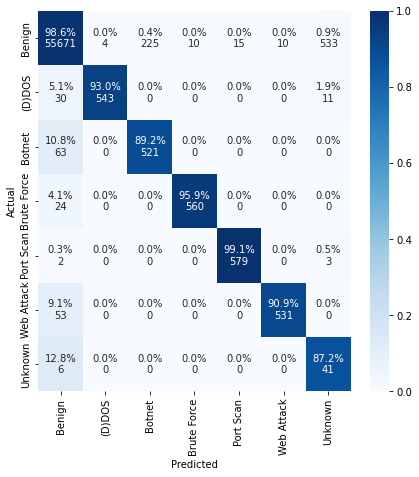

In [31]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)

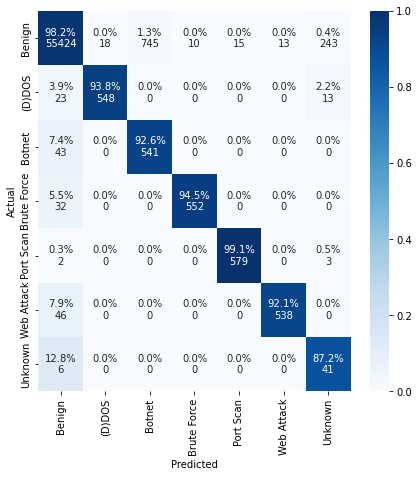

In [42]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)

## Train second stage with anomaly score stage 1 as extra feature

Create probability values of train and validation data

In [38]:
proba_train = -ocsvm_model.decision_function(train['stage2']['x_s'])
proba_val = -ocsvm_model.decision_function(val['stage2']['x_s'])
proba_test = -ocsvm_model.decision_function(test['stage2_s'])

In [46]:
proba_val.shape

(3000,)

In [45]:
val['stage2']['x_s'].shape

(3000, 67)

In [52]:
test['stage2_s'].shape

(59435, 67)

In [49]:
train_with_proba = np.column_stack((train['stage2']['x_s'], proba_train))
val_with_proba = np.column_stack((val['stage2']['x_s'], proba_val))
test_with_proba = np.column_stack((test['stage2_s'], proba_test))

In [50]:
train_with_proba.shape

(5320, 68)

In [51]:
val_with_proba.shape

(3000, 68)

In [53]:
test_with_proba.shape

(59435, 68)

Use new feature set to train and validate the model

In [93]:
params = {
    "n_estimators": 97,
    "max_samples": 0.9034128710297624,
    "max_features": 0.1751204590963604,
    "min_samples_leaf": 1
}
rf_model = create_rf({})
rf_model.fit(train_with_proba, train["stage2"]["y"])

RandomForestClassifier(random_state=42)

In [94]:
y_proba_val_2_extra_feature = rf_model.predict_proba(val_with_proba)

In [95]:
fmacro, fweight, threshold_fscore, f_best = util.optimal_fscore_multi(val['stage2']['y'], y_proba_val_2_extra_feature, rf_model.classes_)
print(f_best["f1_weighted_threshold"])
y_pred_val_2_extra_feature = np.where(np.max(y_proba_val_2_extra_feature, axis=1) > f_best["f1_weighted_threshold"], rf_model.classes_[np.argmax(y_proba_val_2_extra_feature, axis=1)], 'Unknown')

0.9400000000000001


In [97]:
y_proba_test_2_extra_feature = rf_model.predict_proba(test_with_proba)
y_pred_test_2_extra_feature = np.where(np.max(y_proba_test_2_extra_feature, axis=1) > f_best["f1_weighted_threshold"], rf_model.classes_[np.argmax(y_proba_test_2_extra_feature, axis=1)], 'Unknown')
print({
    "f1_macro": f1_score(test["y_unknown_all"], y_pred_test_2_extra_feature, average='macro'),
    "f1_weighted": f1_score(test["y_unknown_all"], y_pred_test_2_extra_feature, average='weighted'),
    'accuracy': accuracy_score(test["y_unknown_all"], y_pred_test_2_extra_feature),
    'balanced_accuracy': balanced_accuracy_score(test["y_unknown_all"], y_pred_test_2_extra_feature)
})

{'f1_macro': 0.8581703603761849, 'f1_weighted': 0.9802877478625802, 'accuracy': 0.9773029359804829, 'balanced_accuracy': 0.9734265804891981}


With default parameters of original training set

In [74]:
{'f1_macro': 0.8581703603761849, 'f1_weighted': 0.9802877478625802, 'accuracy': 0.9773029359804829, 'balanced_accuracy': 0.9734265804891981}


{'f1_macro': 0.8581703603761849,
 'f1_weighted': 0.9802877478625802,
 'accuracy': 0.9773029359804829,
 'balanced_accuracy': 0.9734265804891981}

## Full model performance

In [84]:
# y_proba_2 = predictions['stage2'][9] # Using saved results from initial experiment
y_proba_2 = y_proba_test_2_extra_feature # See training rf above

In [85]:
threshold_m = 0.94 # See table above
y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
np.unique(y_pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  660,   752,   935,   596, 16900,   698]))

In [86]:
y_pred[y_pred == "Fraud"] = y_pred_2
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  660, 38894,   752,   935,   596, 16900,   698]))

In [87]:
threshold_u = 0.0040588613744241275 # See table above
y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
np.unique(y_pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([16323,   577]))

In [88]:
y_pred[y_pred == "Unknown"] = y_pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  660, 55217,   752,   935,   596,   577,   698]))

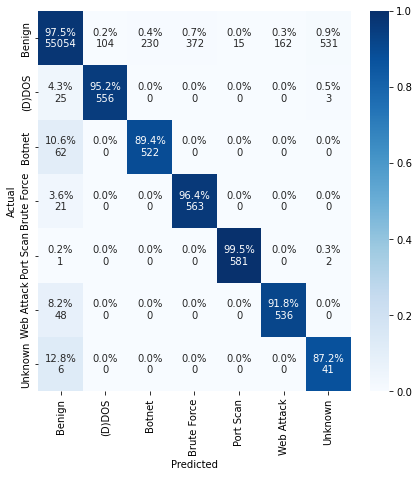

In [89]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)

# With default params

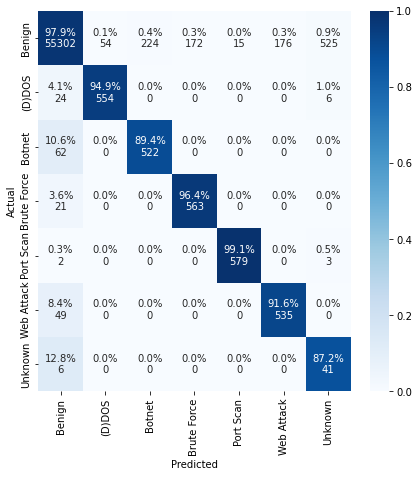

In [70]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)

In [44]:
def generateConfusionGraphs(y_proba_2_new, threshold_m, include_metrics=False):
    fig, axs = plt.subplots(2,3, figsize=(18,12))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.3)
    y_proba_1 = score_test
    metrics = []
    classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
    
    y_pred_1_n = np.where(y_proba_1 < threshold_b, 1, -1)
    confusion_1_binary = util.plot_confusion_matrix(test['y_n'], y_pred_1_n, values=[1, -1], labels=["Benign", "Fraud"], title="Stage 1", ax=axs[0, 0])
    y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud")
    
    y_proba_2 = y_proba_2_new
    y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
    confusion_2_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Fraud"], y_pred_2, values=classes, labels=classes, title="Stage 2", ax=axs[0, 1])

    y_pred = y_pred.astype(object)
    y_pred[y_pred == "Fraud"] = y_pred_2
    if include_metrics:
        result_12 = {
            "threshold_b": threshold_b,
            "threshold_m": threshold_m,
            "threshold_u": "-",
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": "-",
            "zero_day_recall_total": "-"
        }
        metrics.append(result_12)
    confusion_12_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes, title="Stage 1&2 Combined", ax=axs[0, 2])
    mask = ((y_pred == "Unknown") & (test['y_unknown_all'] == "Unknown"))
    
    y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
    y_pred_3_n = np.where(y_proba_1[mask] < threshold_u, 1, -1)
    confusion_3_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Unknown"], y_pred_3, values=classes, labels=classes, title="Extension Multi-Class", ax=axs[1, 0])
    confusion_3_binary = util.plot_confusion_matrix(test['y_n'][mask], y_pred_3_n, values=[1, -1], labels=["Benign", "Zero-Day"], title="Extension Binary", ax=axs[1, 1])

    y_pred[y_pred == "Unknown"] = y_pred_3
    if include_metrics:
        result_123 = {
            "threshold_b": threshold_b,
            "threshold_m": threshold_m,
            "threshold_u": threshold_u,
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": recall_score(test['y_n'][mask], y_pred_3_n, pos_label=-1),
            "zero_day_recall_total": (y_pred_3_n == -1).sum() / 47
        }
        metrics.append(result_123)
    confusion_123_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes, title="Stages 1,2 & Extension Combined", ax=axs[1, 2])
    return pd.DataFrame(metrics)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.00022,0.94,-,0.915611,0.699588,0.699588,0.722330,0.814263,-,-
1,-0.00022,0.94,0.004059,0.938557,0.973383,0.973383,0.764976,0.978406,0.87234,12.170213


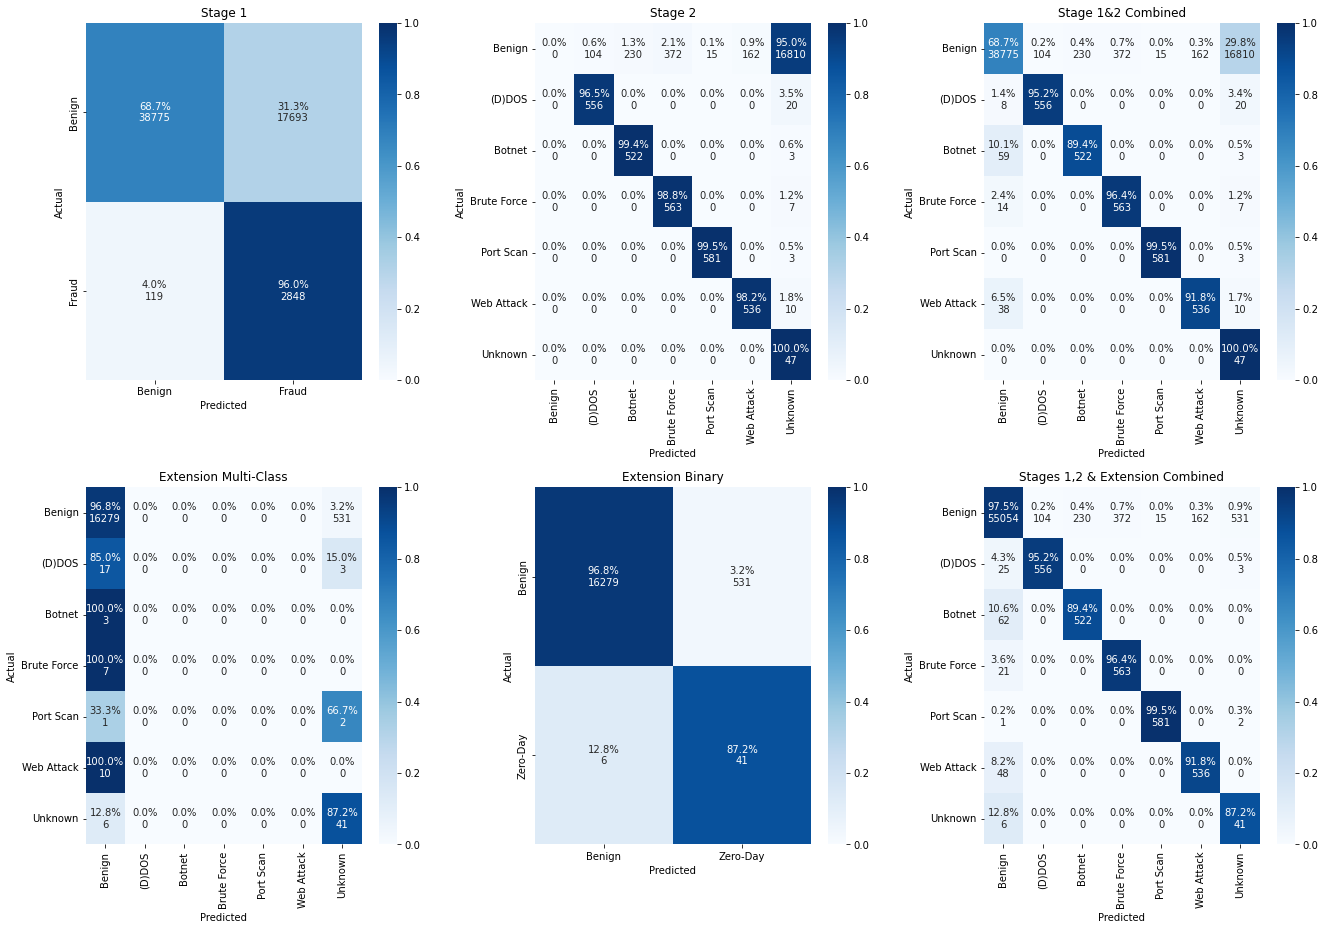

In [91]:
generateConfusionGraphs(y_proba_test_2_extra_feature, 0.94, True)

# Default model params

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.00022,0.94,-,0.914388,0.699504,0.699504,0.742304,0.815638,-,-
1,-0.00022,0.94,0.004059,0.937962,0.977471,0.977471,0.785342,0.981907,0.87234,12.042553


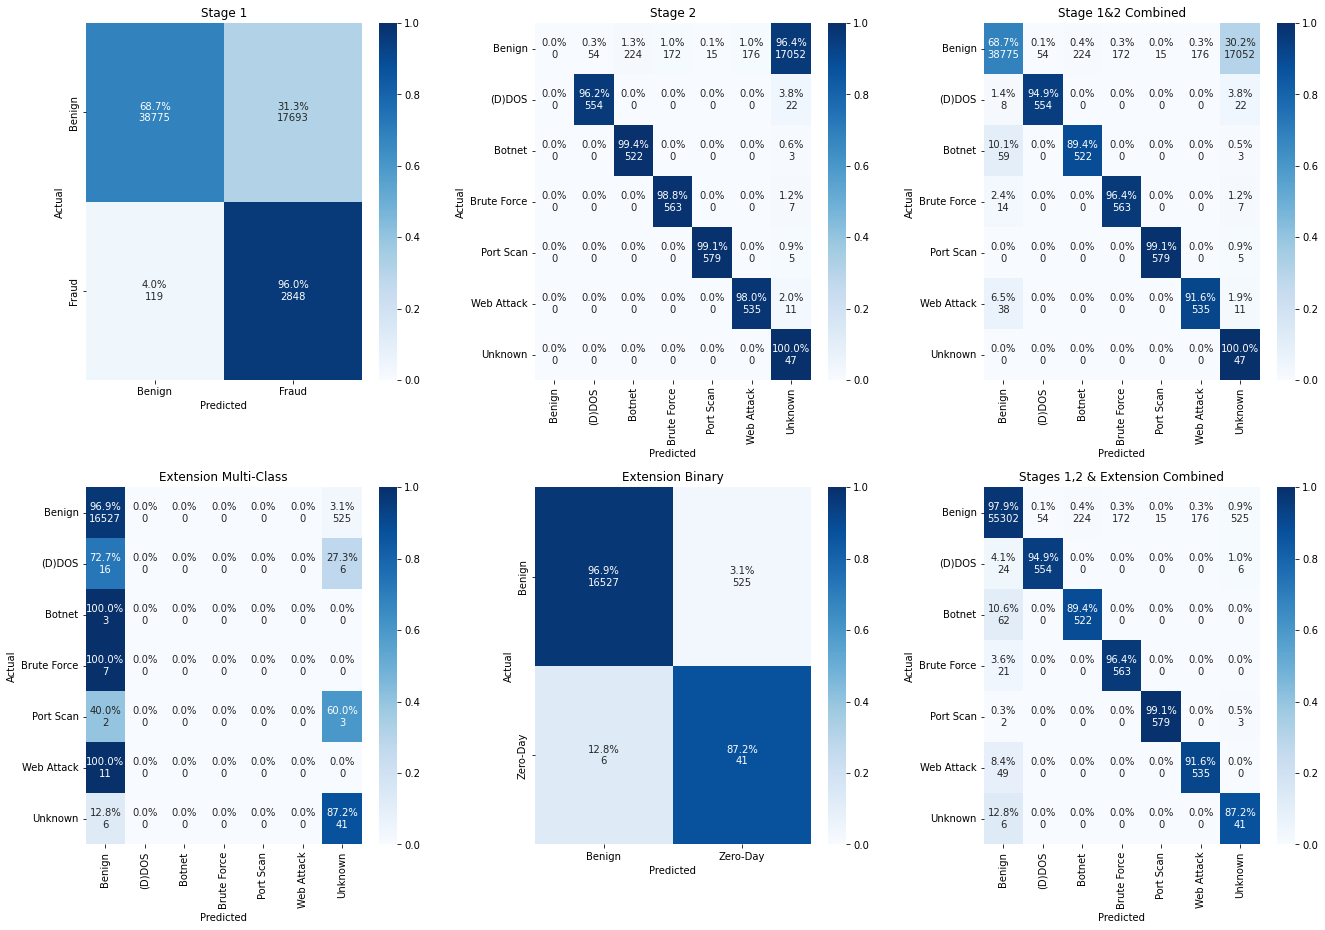

In [98]:
generateConfusionGraphs(y_proba_test_2_extra_feature, 0.94, True)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.00022,0.98,-,0.90656,0.698965,0.698965,0.768003,0.817406,-,-
1,-0.00022,0.98,0.004059,0.93085,0.981694,0.981694,0.811028,0.985864,0.87234,12.212766


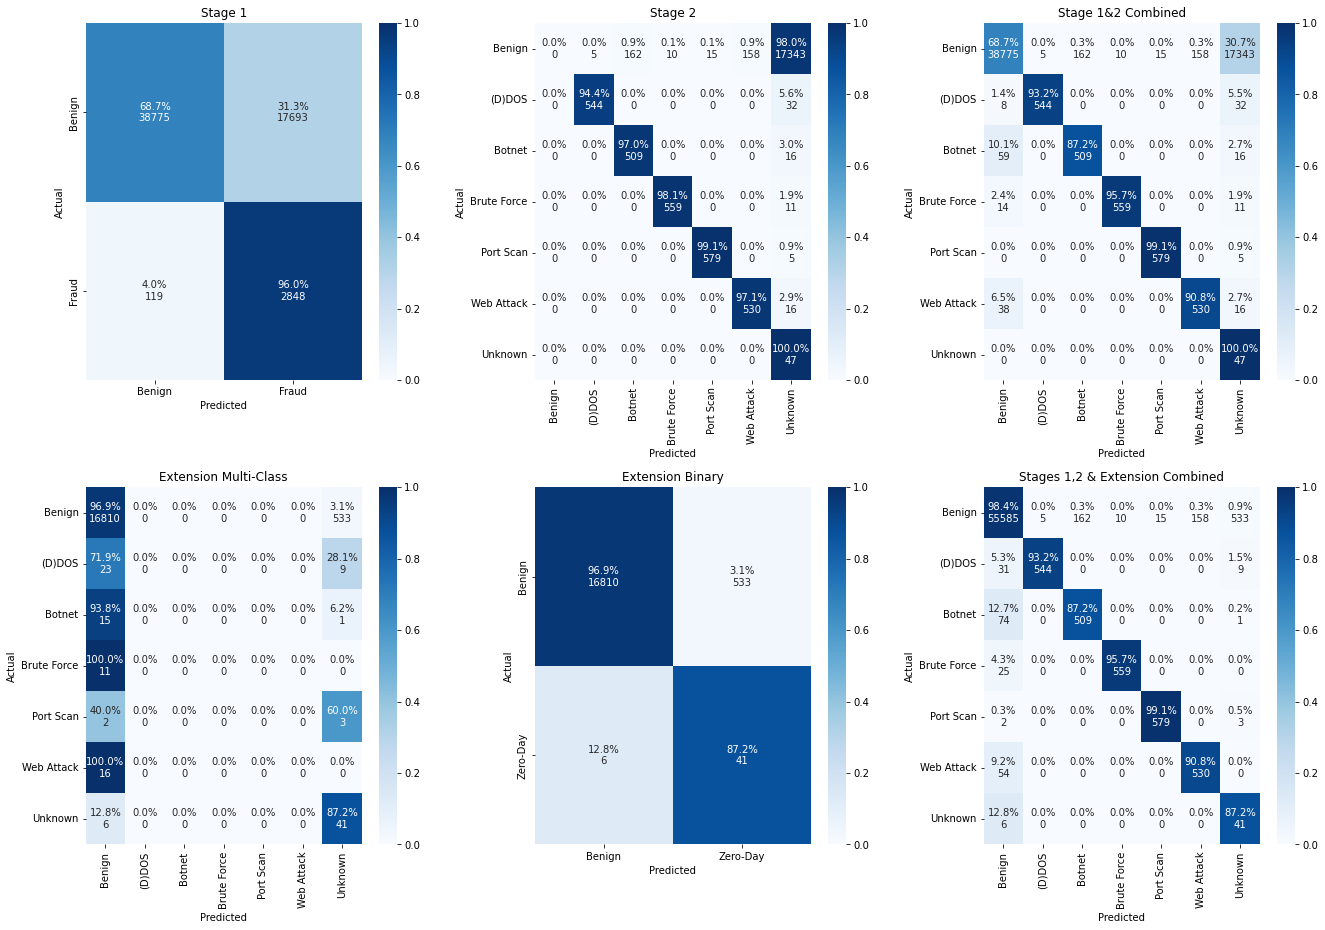

In [99]:
generateConfusionGraphs(y_proba_test_2_extra_feature, 0.98, True)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.00022,0.98,-,0.909740,0.699184,0.699184,0.779970,0.818229,-,-
1,-0.00022,0.98,0.004059,0.934248,0.983360,0.983360,0.823098,0.987539,0.87234,12.212766


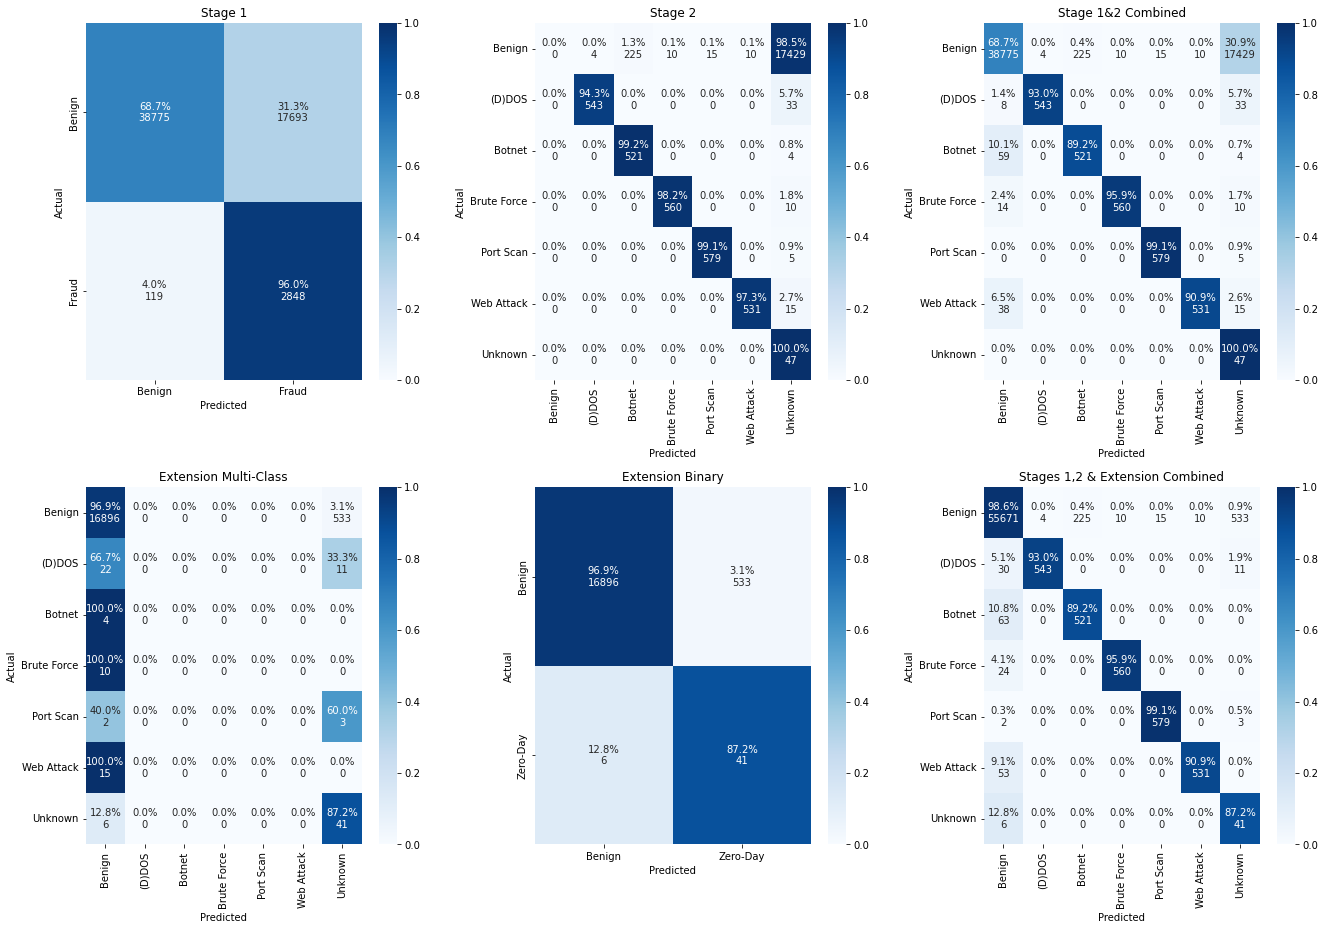

In [92]:
generateConfusionGraphs(y_proba_test_2, 0.98, True)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.0042,0.98,-,0.890497,0.532565,0.532565,0.729327,0.685522,-,-
1,-0.0042,0.98,0.007972,0.939494,0.979608,0.979608,0.807383,0.983615,0.87234,6.042553


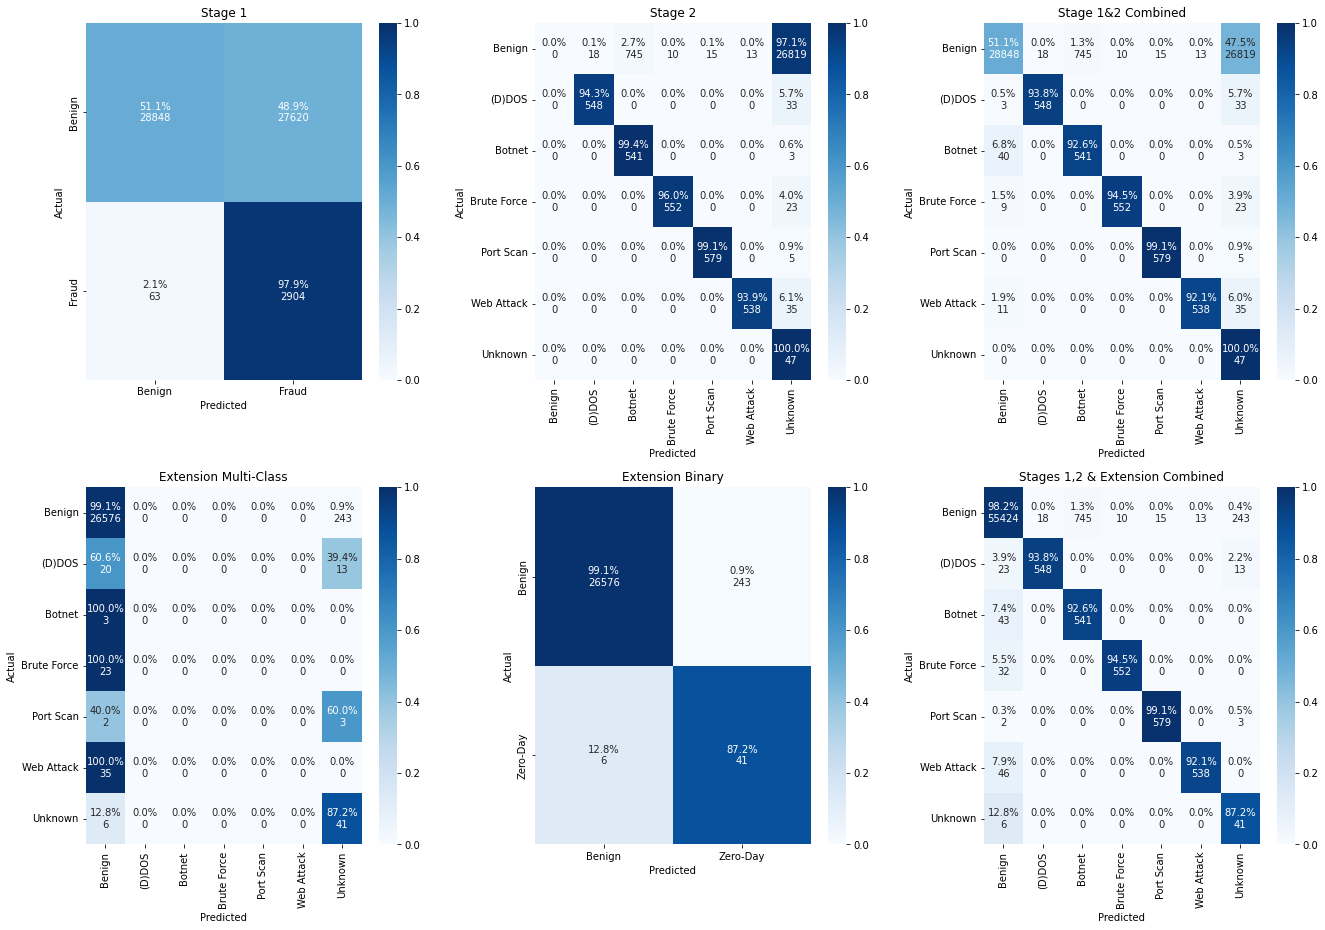

In [45]:
generateConfusionGraphs(y_proba_test_2, 0.98, True)